In [1]:
!pip install numpy==1.23.5

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchfm.model.ffm import FieldAwareFactorizationMachineModel

from tqdm.auto import trange, tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/maksimkoltugin/Desktop/код/ВШЭ/recsys_course_homework_2023/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [3]:
DATA_PATH = '../data/data.csv'

MODEL_PATH = '../data/model.pth'

BATCH_SIZE = 32

In [4]:
def read_data(data_path) -> pd.DataFrame: 
    data = pd.read_csv(data_path, parse_dates=['date_time'])

    # will be used in next HWs
    cols_for_other_hws = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']

    # has only one value for all rows
    cols_constant = ['impressions']

    data = data[data.date_time > '2021-09-26'] # delete outlier
    data.drop(cols_for_other_hws, axis=1, inplace=True)
    data.drop(cols_constant, axis=1, inplace=True)
    data.dropna(inplace=True)

    return data

data = read_data(DATA_PATH)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1


# Analysis

### Посмотрим распределение **по дням**

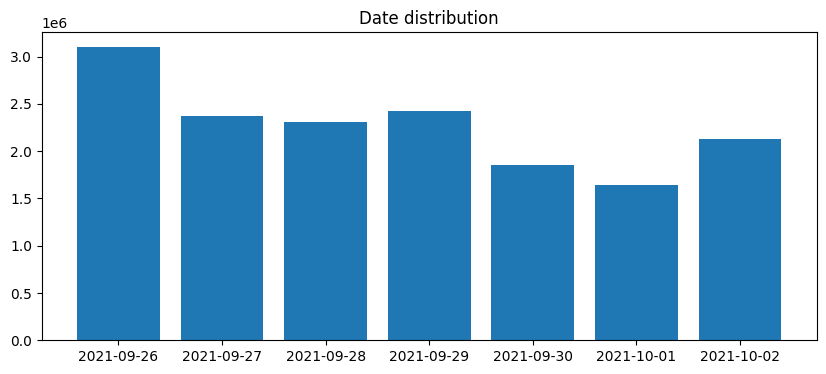

In [5]:
date_counts = data['date_time'].groupby(data['date_time'].dt.date).count()
date_names = date_counts.index.values
y = date_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Date distribution')
plt.bar(bins, height=y)
plt.xticks(bins, date_names)
plt.show()

### Посмотрим распределение **по часам**

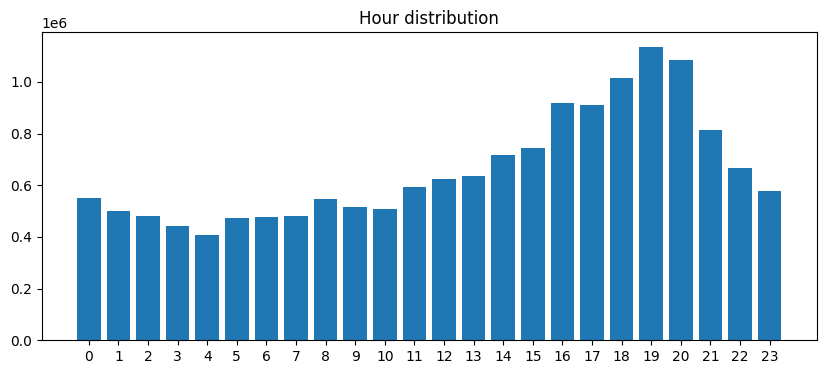

In [6]:
hour_counts = data['date_time'].groupby(data['date_time'].dt.hour).count()
hour_names = hour_counts.index.values
y = hour_counts.values
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Hour distribution')
plt.bar(bins, height=y)
plt.xticks(bins, hour_names)
plt.show()

### Посмотрим на распределение единственной числовой фичи

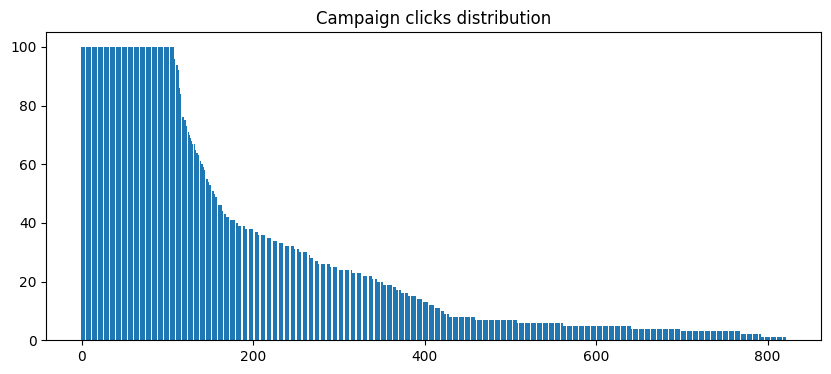

In [7]:
y = data['campaign_clicks'].value_counts().values.copy()
y = y.clip(0, 100)
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('Campaign clicks distribution')
plt.bar(bins, height=y)
plt.show()

### Распределение очень сильно скошено к 0, поэтому будем использовать логарифм этой фичи

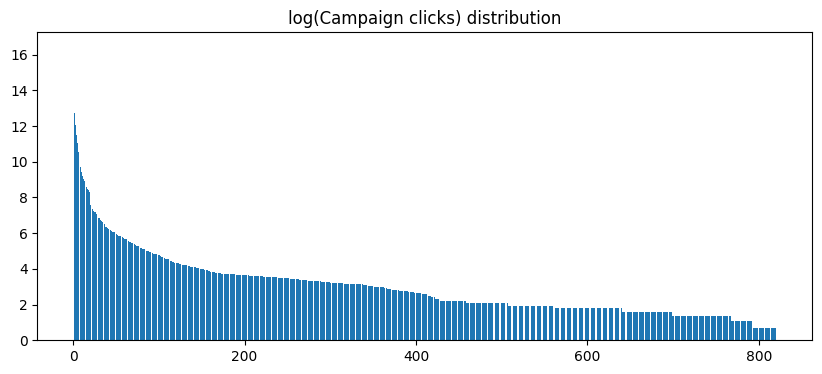

In [8]:
y = data['campaign_clicks'].value_counts().values.copy()
y = np.log(y + 1)
bins = np.arange(len(y))

plt.figure(figsize=(10, 4))
plt.title('log(Campaign clicks) distribution')
plt.bar(bins, height=y)
plt.show()

In [9]:
print('Unique values:')
print(data.nunique())

Unique values:
date_time           604710
zone_id               3444
banner_id             1633
oaid_hash          6510305
campaign_clicks        822
os_id                   11
country_id              17
clicks                   2
dtype: int64


# Feature Engineering

In [10]:
def feature_engineering(data: pd.DataFrame):
    # take log of campaign_clicks
    data['campaign_clicks'] = np.log(data['campaign_clicks'] + 1)

    # add day_of_week and hour features
    data['day'] = data['date_time'].dt.day_of_week
    data['hour'] = data['date_time'].dt.hour

    # add interactions
    data['banner_id/os_id'] = data['banner_id'].astype(str) + '/' + data['os_id'].astype(str)
    data['banner_id/zone_id'] = data['banner_id'].astype(str) + '/' + data['zone_id'].astype(str)

    return data

engineered_data = feature_engineering(data)

print('Unique values:')
print(engineered_data.nunique())

Unique values:
date_time             604710
zone_id                 3444
banner_id               1633
oaid_hash            6510305
campaign_clicks          822
os_id                     11
country_id                17
clicks                     2
day                        7
hour                      24
banner_id/os_id         3689
banner_id/zone_id     195979
dtype: int64


In [11]:
engineered_data[['banner_id/os_id', 'banner_id/zone_id']].head()

,banner_id/os_id,banner_id/zone_id
0,0/0,0/0
1,1/0,1/1
2,2/0,2/2
3,3/1,3/3
4,4/1,4/4


# Prepare data

In [36]:
class Mapper:
    def __init__(self):
        self.mapper = dict()
        self.unknown_idx = 0
        self.curr_idx = 1

    def fit(self, arr):
        for elem in arr:
            if elem not in self.mapper:
                self.mapper[elem] = self.curr_idx
                self.curr_idx += 1

    def transform(self, arr):
        return np.array([self.mapper[elem] if elem in self.mapper else self.unknown_idx for elem in arr])

    def fit_transform(self, arr):
        self.fit(arr)
        return self.transform(arr)


def prepare_data(data):
    # getting train-val-test indices
    last_day = data.date_time.max().date()
    last_but_one_day = last_day - pd.Timedelta(days=1)

    train_index = data[data.date_time.dt.date < last_but_one_day].index
    val_index = data[data.date_time.dt.date == last_but_one_day].index
    test_index = data[data.date_time.dt.date == last_day].index

    # drop date_time column
    data = data.drop(['date_time'], axis=1)

    # get field dimensions
    field_dims = data.drop(['clicks'], axis=1).nunique().values

    # train-val-test split
    train_data = data.loc[train_index]
    val_data = data.loc[val_index]
    test_data = data.loc[test_index]

    # vectorize features
    mapper_banner_os = Mapper()
    train_data['banner_id/os_id'] = mapper_banner_os.fit_transform(train_data['banner_id/os_id'].values)
    val_data['banner_id/os_id'] = mapper_banner_os.transform(val_data['banner_id/os_id'].values)
    test_data['banner_id/os_id'] = mapper_banner_os.transform(test_data['banner_id/os_id'].values)

    mapper_banner_zone = Mapper()
    train_data['banner_id/zone_id'] = mapper_banner_zone.fit_transform(train_data['banner_id/zone_id'].values)
    val_data['banner_id/zone_id'] = mapper_banner_zone.transform(val_data['banner_id/zone_id'].values)
    test_data['banner_id/zone_id'] = mapper_banner_zone.transform(test_data['banner_id/zone_id'].values)

    mapper_oaid_hash = Mapper()
    train_data['oaid_hash'] = mapper_oaid_hash.fit_transform(train_data['oaid_hash'].values)
    val_data['oaid_hash'] = mapper_oaid_hash.transform(val_data['oaid_hash'].values)
    test_data['oaid_hash'] = mapper_oaid_hash.transform(test_data['oaid_hash'].values)

    # scaling campaign_clicks
    scaler = StandardScaler()
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    data = data.drop(['campaign_clicks'], axis=1)
    # train_data['campaign_clicks'] = scaler.fit_transform(train_data['campaign_clicks'].values.reshape(-1, 1)).flatten()
    # val_data['campaign_clicks'] = scaler.transform(val_data['campaign_clicks'].values.reshape(-1, 1)).flatten()
    # test_data['campaign_clicks'] = scaler.transform(test_data['campaign_clicks'].values.reshape(-1, 1)).flatten()

    # features
    X_train = torch.tensor(train_data.drop(['clicks'], axis=1).values)
    X_val = torch.tensor(val_data.drop(['clicks'], axis=1).values)
    X_test = torch.tensor(test_data.drop(['clicks'], axis=1).values)

    # target
    y_train = torch.tensor(train_data['clicks'].values)
    y_val = torch.tensor(val_data['clicks'].values)
    y_test = torch.tensor(test_data['clicks'].values)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), field_dims, scaler, mapper_banner_os, mapper_banner_zone


(X_train, y_train), (X_val, y_val), (X_test, y_test), field_dims, _, _, _ = prepare_data(engineered_data)

print(f'features:        {X_train.shape[1]}\n')

print(f'train size:      {len(y_train)}')
print(f'validation size: {len(y_val)}')
print(f'test size:       {len(y_test)}\n')

print(f'field dims: {field_dims.tolist()}')

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

features:        9

train size:      12049017
validation size: 1643448
test size:       2128978

field dims: [3444, 1633, 6510305, 11, 17, 7, 24, 3689, 195979]


# Hyperparams selection

# Train

In [38]:
embed_dim = 5
model = FieldAwareFactorizationMachineModel(field_dims, embed_dim).to(device)

def train(model, epochs, train_loader, optimizer, criterion):
    model.train()
    losses = []

    for _ in trange(epochs):
        for X_batch, y_batch in tqdm(train_loader):    
            for ob in X_batch:
                for x, field_dim in zip(ob, field_dims):
                    assert x < field_dim, f'{x}, {field_dim}'
                              
            X_batch = X_batch.to(device).long()            
            y_batch = y_batch.to(device).float()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

train(
    model=model,
    epochs=1,
    train_loader=train_loader,
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001),
    criterion=torch.nn.BCELoss()
)

  0%|          | 0/1 [00:48<?, ?it/s]


KeyboardInterrupt: 

# Perfomance